In [1]:
# Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re
%matplotlib inline
from scipy import stats
from matplotlib.ticker import FuncFormatter
from matplotlib.legend import Legend

In [2]:
# Theme
myrcs = {"axes.titleweight": "bold", "lines.markersize": 9.0, "lines.linewidth": 2.0, "legend.title_fontsize": 13.75}
sns.set (style="whitegrid", font_scale=1.35, rc=myrcs)
sns.set_palette (sns.color_palette (["#b2df8a", "#33a02c", "#cab2d6", "#6a3d9a"]))
sns.set_palette (sns.color_palette (["#b2df8a", "#33a02c", "#fdbf6f", "#ff7f00"]))
sns.set_palette (sns.color_palette ("Paired"))

# Min rows shown
pd.options.display.min_rows = 20

In [3]:
# Configurations
# A5 - with HW switch, can increase/decrease number of SW switches (maximum number of SW = 5)
# B - without HW switch, can increase/decrease number of SW switches (maximum number of SW = 5)
# D - with HW switch, cannot increase/decrease number of SW switches (number of SW fixed at 5)
# E - without HW switch, cannot increase/decrease number of SW switches (number of SW fixed at 5)

#Names of settings in graphics:
# D = (HW = 1; SW = 5); B = (HW = 0; SW = 1-5); A5 = (HW = 1; SW = 1-5); E = (HW = 0; SW = 5) 

# Simulation parameters
seeds = [1,2,3,4,5,6,7,8,9,10]
cargas = ["50hosts", "100hosts", "150hosts"]
experimentos = ["e","b","d","a5"]

# Simulation time
t_sim = 2000

# Confidence interval
confianca = 99

# Print the title
titulos = False

# Save graphics
salvarGraficos = False

In [4]:
# Functions to read log files
def mymode (series):
    return stats.mode (series)[0]

agg_map = {'SwAtivosAntes' : mymode, 'SwAtivosDepois' : np.mean, 'AvgCPULoad' : np.mean}

def read_df_decisao ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("logs/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-logDecisaoSwitchesSW.log", sep='\s+', index_col=["TimeSec"])
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Load","Experimento","Seed","TimeSec"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read

def read_df_statistics ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("logs/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-statistics.log", sep='\s+', index_col=["TimeSec"])
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Load","Experimento","Seed","TimeSec"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read

def read_df_hw ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("logs/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-switch-stats-hw.log", sep='\s+', index_col=["TimeSec"])
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Load","Experimento","Seed","TimeSec"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read

def read_df_sw ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            if(experimento[0] == "a"):
                numSW = int(experimento[1])
            else:
                numSW = 5
            df_sw = []
            for sw in range(1,numSW+1):
                df_sed = []
                for seed in seeds:
                    df = pd.read_csv ("logs/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-switch-stats-sw"+str(sw)+".log", sep='\s+', index_col=["TimeSec"])
                    df_sed.append (df)
                df_sw.append(pd.concat (df_sed, keys=seeds))
            df_exp.append(pd.concat(df_sw, keys=range(1,numSW+1)))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Load","Experimento","NumSW","Seed","TimeSec"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read

def read_df_ping ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("logs/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-pingHW.log", sep='\s+', index_col=["seq"])
                df['Switch'] = "HW"
                df_sed.append (df)
                df = pd.read_csv ("logs/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-pingSW.log", sep='\s+', index_col=["seq"])
                df['Switch'] = "SW"
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Load","Experimento","Seed","TimeSec"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read

def read_df_iperfs ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("logs/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-iperfs.log", sep='\s+')
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed))
        df_carga.append (pd.concat (df_exp))
    df_read = pd.concat (df_carga, keys=cargas, copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read


In [5]:
df_sw = read_df_sw()
df_sw = df_sw.loc[(df_sw["LoaKbps"]!=0)]
df_sw["%drop"] = (df_sw["LoaDrps"]/(df_sw["Packets"]+df_sw["LoaDrps"]))*100
df_sw.rename({"e": "HW = 0\n SW = 5", "d": "HW = 1\n SW = 5",  "b": "HW = 0\nSW = 1-5" , "a5": "HW = 1\nSW = 1-5"}, inplace=True)
df_sw = df_sw.query("TimeSec > 200 and TimeSec < 400").groupby(["Load", "Experimento", "Seed"]).mean()
df_sw.reset_index(inplace=True)

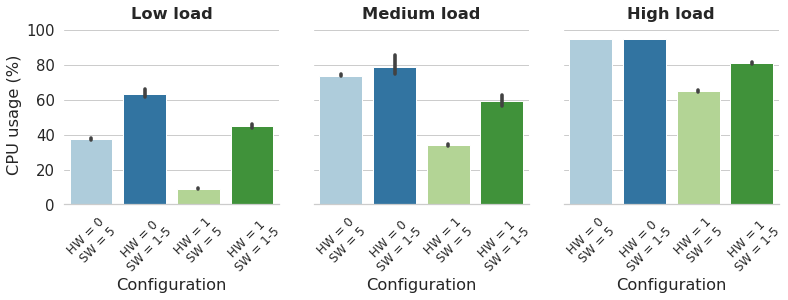

In [6]:
snsplt = sns.catplot( x="Experimento", y="LoaUsag", kind="bar", height=3.5, aspect=1,
                      ci=confianca, data=df_sw, col="Load",col_order=["Low","Medium","High"])
snsplt.set_titles("{col_name} load")
snsplt.set_axis_labels("Configuration", "CPU usage (%)")
if (titulos):
    snsplt.fig.suptitle('Uso dos switches SW (CPU)', y=1.05)
snsplt.set(ylim=(0,103))
snsplt.set_xticklabels(rotation=45, size=12)
snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
if (salvarGraficos):
    snsplt.savefig("Images/SS-CPUSW.pdf")

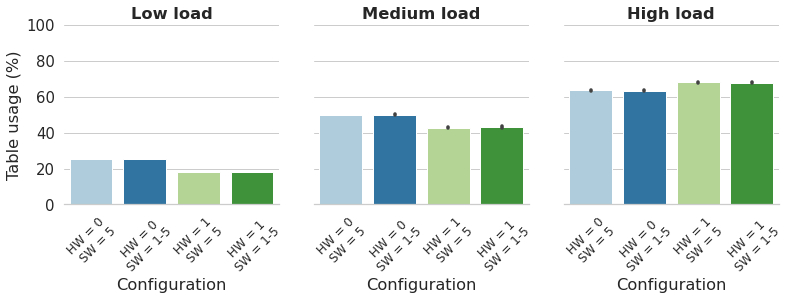

In [7]:
snsplt = sns.catplot( x="Experimento", y="FloUsag", kind="bar",  height=3.5, aspect=1,
                      ci=95, data=df_sw, col="Load",col_order=["Low","Medium","High"])
snsplt.set_titles("{col_name} load")
snsplt.set_axis_labels("Configuration", "Table usage (%)")
if (titulos):
    snsplt.fig.suptitle('Uso dos switches SW (Tabela)', y=1.05)
snsplt.set(ylim=(0,100))
snsplt.set_xticklabels(rotation=45, size=12)
snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
if (salvarGraficos):
    snsplt.savefig("Images/SS-TableSW.pdf")

In [8]:
df_decisao = read_df_decisao()
df_decisao.rename({"e": "HW = 0\n SW = 5", "d": "HW = 1\n SW = 5",  "b": "HW = 0\nSW = 1-5" , "a5": "HW = 1\nSW = 1-5"}, inplace=True)

In [9]:
df_decisao = df_decisao.query("TimeSec > 200 and TimeSec < 400").groupby(["Load", "Experimento", "Seed"]).mean()
df_decisao.reset_index(inplace=True)

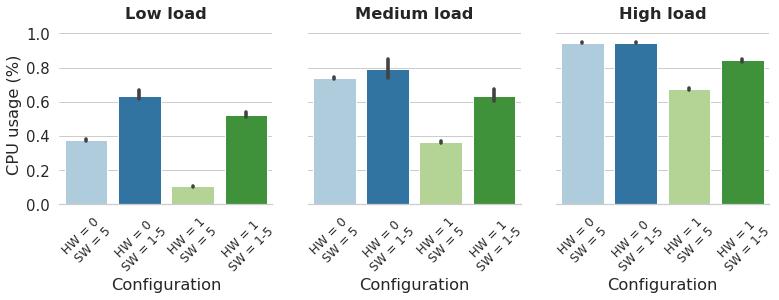

In [10]:
snsplt = sns.catplot( x="Experimento", y="AvgCPULoad", kind="bar",  height=3.5, aspect=1,
                      ci=confianca, data=df_decisao, col="Load",col_order=["Low","Medium","High"])
snsplt.set_titles("{col_name} load")
snsplt.set_axis_labels("Configuration", "CPU usage (%)")
if (titulos):
    snsplt.fig.suptitle('Uso do switch SW (CPU) - gráfico igual', y=1.05)
snsplt.set(ylim=(0,1.05))
snsplt.set_xticklabels(rotation=45, size=12)
snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)

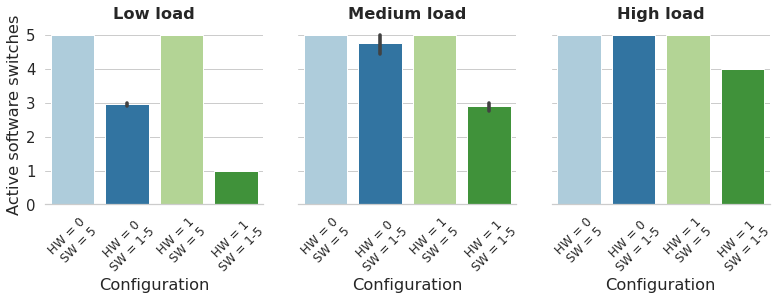

In [11]:
snsplt = sns.catplot( x="Experimento", y="SwAtivosDepois", kind="bar",  height=3.5, aspect=1,
                      ci=confianca, data=df_decisao, col="Load",col_order=["Low","Medium","High"])
snsplt.set_titles("{col_name} load")
snsplt.set_axis_labels("Configuration", "Active software switches")
if (titulos):
    snsplt.fig.suptitle('Número de switches SW ativos', y=1.05)
snsplt.set(ylim=(0,5.3), yticks=(0,1,2,3,4,5))
snsplt.set_xticklabels(rotation=45, size=12)
snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
if (salvarGraficos):
    snsplt.savefig("Images/SS-NumberActiveSW.pdf")

In [12]:
df_stats = read_df_statistics()
df_stats.rename({"e": "HW = 0\n SW = 5", "d": "HW = 1\n SW = 5",  "b": "HW = 0\nSW = 1-5" , "a5": "HW = 1\nSW = 1-5"}, inplace=True)

In [13]:
df_stats_bloq = df_stats[["RegrasBloqueadas", "RegrasAceitas"]].query("TimeSec > 200 and TimeSec < 400").groupby(["Load", "Experimento", "Seed"]).sum()
df_stats_bloq.reset_index(inplace=True)
df_stats_bloq["block"] = (df_stats_bloq["RegrasBloqueadas"]/(df_stats_bloq["RegrasAceitas"]+df_stats_bloq["RegrasBloqueadas"]) ) *100

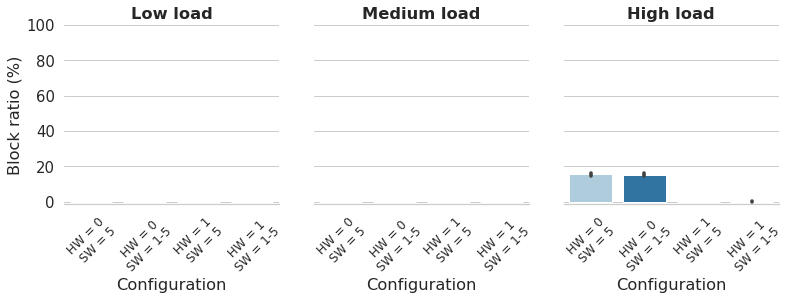

In [14]:
snsplt = sns.catplot( x="Experimento", y="block", kind="bar",  height=3.5, aspect=1,
                      ci=confianca, data=df_stats_bloq, col="Load",col_order=["Low","Medium","High"])
snsplt.set_titles("{col_name} load")
snsplt.set_axis_labels("Configuration", "Block ratio (%)")
if (titulos):
    snsplt.fig.suptitle('Regras bloqueadas', y=1.05)
snsplt.set(ylim=(-1.5,100))
snsplt.set_xticklabels(rotation=45, size=12)
snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
if (salvarGraficos):
    snsplt.savefig("Images/SS-Blocks.pdf")

In [15]:
df_hw = read_df_hw()
df_hw.rename({"e": "HW = 0\n SW = 5", "d": "HW = 1\n SW = 5",  "b": "HW = 0\nSW = 1-5" , "a5": "HW = 1\nSW = 1-5"}, inplace=True)

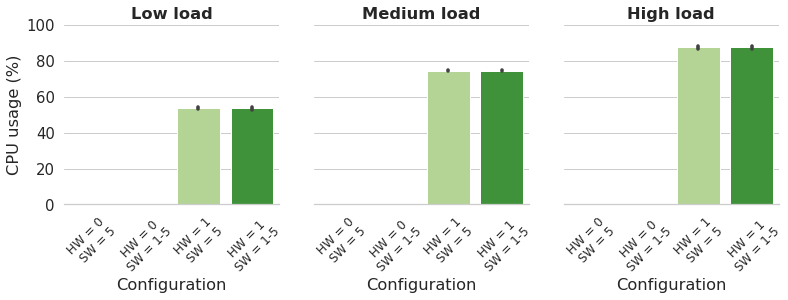

In [16]:
df_hw = df_hw.query("TimeSec > 200 and TimeSec < 400").groupby(["Load", "Experimento", "Seed"]).mean()
df_hw.reset_index(inplace=True)
snsplt = sns.catplot( x="Experimento", y="LoaUsag", kind="bar",  height=3.5, aspect=1,
                      ci=confianca, data=df_hw, col="Load",col_order=["Low","Medium","High"])
snsplt.set_titles("{col_name} load")
snsplt.set_axis_labels("Configuration", "CPU usage (%)")
if (titulos):
    snsplt.fig.suptitle('Uso do switch HW (CPU)', y=1.05)
snsplt.set(ylim=(0,100))
snsplt.set_xticklabels(rotation=45, size=12)
snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
if (salvarGraficos):
    snsplt.savefig("Images/SS-CPUHW.pdf")

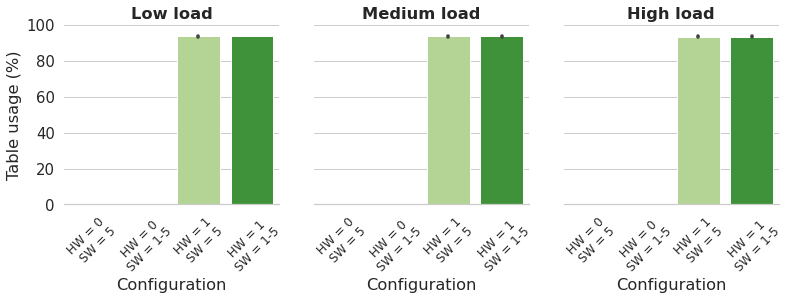

In [17]:
snsplt = sns.catplot( x="Experimento", y="FloUsag", kind="bar",  height=3.5, aspect=1,
                      ci=confianca, data=df_hw, col="Load",col_order=["Low","Medium","High"])
snsplt.set_titles("{col_name} load")
snsplt.set_axis_labels("Configuration", "Table usage (%)")
if (titulos):
    snsplt.fig.suptitle('Uso do switch HW (Tabela)', y=1.05)
snsplt.set(ylim=(0,100))
snsplt.set_xticklabels(rotation=45, size=12)
snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
if (salvarGraficos):
    snsplt.savefig("Images/SS-TableHW.pdf")

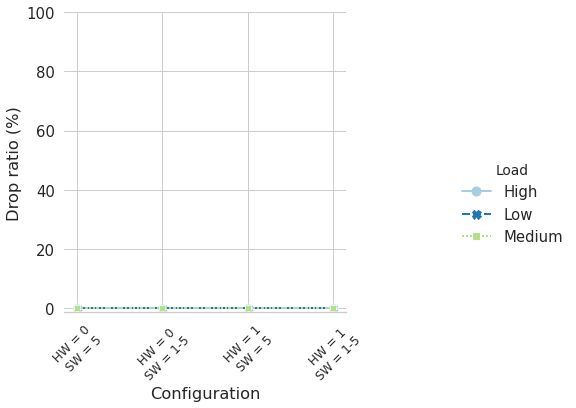

In [18]:
snsplt = sns.relplot(x="Experimento", y="%drop", height=3.5, aspect=1,
            hue="Load",
            kind="line", legend="full", data=df_sw, ci=95, style="Load", markers=True)
snsplt.set_titles("{col_name} load")
snsplt.set_axis_labels("Configuration", "Drop ratio (%)")
if (titulos):
    snsplt.fig.suptitle('Load drops SW', y=1.05)
snsplt.set(ylim=(-1.5,100))
snsplt.set_xticklabels(rotation=45, size=12)
snsplt.fig.set_size_inches(10,6)
snsplt.despine(left=True)
if (salvarGraficos):
    snsplt.savefig("Images/SS-LoadDropsSW.pdf")

In [19]:
df_sw = read_df_sw()
df_sw = df_sw.query("TimeSec > 200 and TimeSec < 400")[["LoaKbps","Packets"]]
df_sw = df_sw.loc[(df_sw["Packets"]!=0)]
df_sw = df_sw.groupby(["Load", "Experimento", "NumSW", "Seed"]).mean()[["LoaKbps"]]
df_sw = df_sw.groupby(["Load", "Experimento", "Seed"]).sum()
df_sw = df_sw.rename(columns={"LoaKbps" : "LoaKbpsSW"})

df_hw = read_df_hw()
df_hw = df_hw.query("TimeSec > 200 and TimeSec < 400")[["LoaKbps","Packets"]]
df_hw = df_hw.loc[(df_hw["Packets"]!=0)]
df_hw = df_hw.groupby(["Load", "Experimento", "Seed"]).mean()[["LoaKbps"]]
df_hw = df_hw.rename(columns={"LoaKbps" : "LoaKbpsHW"})

df_total = pd.concat([df_sw, df_hw], axis=1)
df_total["Soma"] = df_total["LoaKbpsSW"] + df_total["LoaKbpsHW"]
df_total.rename({"e": "HW = 0\n SW = 5", "d": "HW = 1\n SW = 5",  "b": "HW = 0\nSW = 1-5" , "a5": "HW = 1\nSW = 1-5"}, inplace=True)
df_total.reset_index(inplace = True)
df_total['Soma'] = df_total['Soma']/1e6

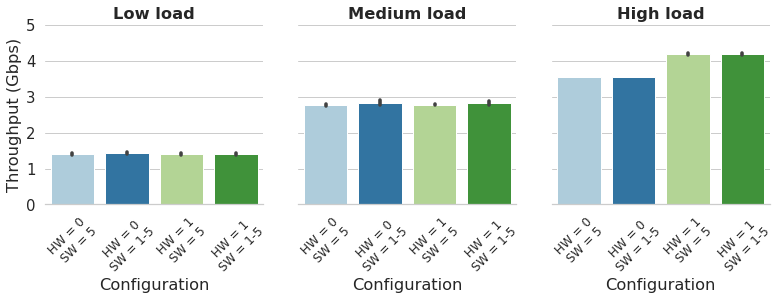

In [20]:
snsplt = sns.catplot( x="Experimento", y="Soma", kind="bar",  height=3.5, aspect=1,
                      ci=confianca, data=df_total, col="Load", col_order=["Low","Medium","High"], order=["HW = 0\n SW = 5", "HW = 0\nSW = 1-5", "HW = 1\n SW = 5", "HW = 1\nSW = 1-5"])
snsplt.set_titles("{col_name} load")
snsplt.set_axis_labels("Configuration", "Throughput (Gbps)")
if (titulos):
    snsplt.fig.suptitle('Vazão Agregada Média', y=1.05)
snsplt.set(ylim=(0,5))
snsplt.set_xticklabels(rotation=45, size=12)
snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
if (salvarGraficos):
    snsplt.savefig("Images/SS-Throughput.pdf")